In [1]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error, adjusted_rand_score
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from ipywidgets import FloatProgress
from IPython.display import display
%matplotlib inline

In [91]:
def fit_scatter(y_true, y_pred,filename=None,title=None):
    assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    m, b = np.polyfit(y_true, y_pred, 1)
    ax.scatter(y_true, y_pred, marker='o',color='b',label='RP genes')
    ax.plot(y_true, m*y_true + b,'--', color='g',lw=2,label='Pearson\'s R: {0:.3f}'.format(np.corrcoef(y_true, y_pred)[0][1]))
    ax.set_ylim(ymin=0,ymax=1)
    ax.legend(loc=4)
    #ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4,color='w')
    ax.set_xlabel('Observed AUC')
    ax.set_ylabel('Predicted AUC')
    if title is not None:
        ax.set_title('{}'.format(title))
    if filename is not None:
        fig.savefig('images/{}.pdf',filename)

In [93]:
def fit_scatter_nrp(y_true, y_pred,filename=None,title=None):
    assert y_true.shape == y_pred.shape
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    m, b = np.polyfit(y_true, y_pred, 1)
    ax.scatter(y_true, y_pred, marker='o',color='r',label='nonRP genes')
    ax.plot(y_true, m*y_true + b,'--', color='g',lw=2,label='Pearson\'s R: {0:.3f}'.format(np.corrcoef(y_true, y_pred)[0][1]))
    ax.set_ylim(ymin=0,ymax=1)
    ax.legend(loc=4)
    #ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4,color='w')
    ax.set_xlabel('Observed AUC')
    ax.set_ylabel('Predicted AUC')
    if title is not None:
        ax.set_title('{}'.format(title))
    if filename is not None:
        fig.savefig('images/{}.pdf',filename)

In [89]:
def fit_scatter_multi(y_true1,y_true2, y_pred1, y_pred2,filename=None,title=None):
#     assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    plt.style.use('ggplot')
    ax.scatter(y_true1, y_pred1,color='blue',label='RP genes')
    ax.scatter(y_true2, y_pred2, color='red',label='nonRP genes')
    
    y_true = np.concatenate((y_true1,y_true2),axis=0)
    y_pred = np.concatenate((y_pred1,y_pred2),axis=0)
    
    m, b = np.polyfit(y_true, y_pred, 1)
    ax.plot(y_true, m*y_true + b,linestyle='dashed', color='g',lw=2,label='Pearson\'s R: {0:.3f}'.format(np.corrcoef(y_true, y_pred)[0][1]))
    ax.set_ylim(ymin=0,ymax=1)
    ax.legend(loc=4)
    #ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4,color='w')
    ax.set_xlabel('Observed AUC')
    ax.set_ylabel('Predicted AUC')
    if title is not None:
        ax.set_title('{}'.format(title))
    if filename is not None:
        plt.savefig('images/{}.pdf'.format(filename))

In [74]:
def plot_importance(feature_importance,names,filename=None):
    plt.figure(figsize=(6, 8))
    plt.style.use('ggplot')
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center',color='b')
    plt.yticks(pos, names[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('RF variable importance')
    plt.tight_layout()
    if filename is not None:
        plt.savefig('images/{}.pdf'.format(filename))
    plt.show()
    

In [6]:
def plot_imp(feature_importance,names):
    print(names)
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    fig2, ax2 = plt.subplots(figsize=(10,15))
    ax2.barh(pos, feature_importance[sorted_idx], align='center')
    ax2.set_yticks(pos, names[sorted_idx])
    ax2.set_xlabel('RF feature importance')

In [5]:
def print_stats(true,predictions):
    print('Coefficient of determination R^2: {}'.format(r2_score(true, predictions)))
    print('Mean squared error:               {}'.format(mean_squared_error(true, predictions)))
    print('Mean absolute error:              {}'.format(mean_absolute_error(true, predictions)))
    print('Root mean squared error:          {}'.format(np.sqrt(mean_squared_error(true, predictions))))
    print('Correlation Coefficient:          {}'.format(np.corrcoef(true, predictions)[0][1]))

In [6]:
def get_best_settings(results_1,results_2):
    best_result_1 = results_1[0][0][0]
    best_result_2 = results_2[0][0][0]
    best_difference = results_2[0][0][0] - results_1[0][0][0]

    best_i_1=0
    best_j_1=0
    best_k_1=0

    best_i_2=0
    best_j_2=0
    best_k_2=0

    best_i_3=0
    best_j_3=0
    best_k_3=0
    

    mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
    md = [5,7,10,12,15,18,20]
    n_est = [10,20,30,40,50,60,80,90,100,120,140,160]
    
    for i in range(len(mxf)):
        for j in range(len(md)):
            for k in range(len(n_est)):
                if best_result_1 < results_1[i][j][k]:
                    best_result_1 = results_1[i][j][k]
                    best_i_1=i
                    best_j_1=j
                    best_k_1=k
                if best_result_2 < results_2[i][j][k]:
                    best_result_2 = results_2[i][j][k]
                    best_i_2=i
                    best_j_2=j
                    best_k_2=k
                if best_difference < results_2[i][j][k] - results_1[i][j][k]:
                    best_difference = results_2[i][j][k] - results_1[i][j][k]
                    best_i_3=i
                    best_j_3=j
                    best_k_3=k

#     print('{} {} {} : {}'.format(best_i_1,best_j_1,best_k_1,best_result_1))
#     print('{} {} {} : {}'.format(best_i_2,best_j_2,best_k_2,best_result_2))
#     print('{} {} {} : {}'.format(best_i_3,best_j_3,best_k_3,best_difference))

    print('Normal best: {} | max_features: {}; max_depth: {}; n_estimators: {};'.format(best_result_1,mxf[best_i_1],md[best_j_1],n_est[best_k_1]))
    print('Extended best: {} | max_features: {}; max_depth: {}; n_estimators: {};'.format(best_result_2,mxf[best_i_2],md[best_j_2],n_est[best_k_2]))
    print('Best difference: {} | max_features: {}; max_depth: {}; n_estimators: {};'.format(best_difference,mxf[best_i_3],md[best_j_3],n_est[best_k_3]))
    
    return mxf[best_i_1],md[best_j_1],n_est[best_k_1],mxf[best_i_2],md[best_j_2],n_est[best_k_2]

In [7]:
data_path = os.path.join(os.getcwd(), 'datasets', 'features.csv')
data_path_rp = os.path.join(os.getcwd(), 'datasets', 'rp_features.csv')
data_path_nrp = os.path.join(os.getcwd(), 'datasets', 'nrp_features.csv')

data_path_extended = os.path.join(os.getcwd(), 'datasets', 'extended_features.csv')
data_path_rp_extended = os.path.join(os.getcwd(), 'datasets', 'rp_extended_features.csv')
data_path_nrp_extended = os.path.join(os.getcwd(), 'datasets', 'nrp_extended_features.csv')

data_path_cut = os.path.join(os.getcwd(), 'datasets', 'features_cut.csv')
data_path_extended_cut = os.path.join(os.getcwd(), 'datasets', 'extended_features_cut.csv')

data_path_rp_cut = os.path.join(os.getcwd(), 'datasets', 'rp_features_cut.csv')
data_path_nrp_cut = os.path.join(os.getcwd(), 'datasets', 'nrp_features_cut.csv')
data_path_rp_extended_cut = os.path.join(os.getcwd(), 'datasets', 'rp_extended_features_cut.csv')
data_path_nrp_extended_cut = os.path.join(os.getcwd(), 'datasets', 'nrp_extended_features_cut.csv')

gene_features = pd.read_csv(data_path, delimiter = ',')
rp_gene_features = pd.read_csv(data_path_rp, delimiter = ',')
nrp_gene_features = pd.read_csv(data_path_nrp, delimiter = ',')

extended_features = pd.read_csv(data_path_extended, delimiter = ',')
rp_extended_features = pd.read_csv(data_path_rp_extended, delimiter = ',')
nrp_extended_features = pd.read_csv(data_path_nrp_extended, delimiter = ',')

gene_features_cut = pd.read_csv(data_path_cut, delimiter = ',')
extended_features_cut = pd.read_csv(data_path_extended_cut, delimiter = ',')
rp_features_cut = pd.read_csv(data_path_rp_cut, delimiter = ',')
rp_extended_features_cut = pd.read_csv(data_path_rp_extended_cut, delimiter = ',')
nrp_features_cut = pd.read_csv(data_path_nrp_cut, delimiter = ',')
nrp_extended_features_cut = pd.read_csv(data_path_nrp_extended_cut, delimiter = ',')

print('Number of data points: {}. Number of attributes: {}'.format(gene_features.shape[0],gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(extended_features.shape[0],extended_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(rp_gene_features.shape[0],rp_gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(rp_extended_features.shape[0],rp_extended_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(nrp_gene_features.shape[0],nrp_gene_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(nrp_extended_features.shape[0],nrp_extended_features.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(gene_features_cut.shape[0],gene_features_cut.shape[1]))
print('Number of data points: {}. Number of attributes: {}'.format(extended_features_cut.shape[0],extended_features_cut.shape[1]))

Number of data points: 117. Number of attributes: 101
Number of data points: 117. Number of attributes: 106
Number of data points: 84. Number of attributes: 101
Number of data points: 84. Number of attributes: 106
Number of data points: 33. Number of attributes: 101
Number of data points: 33. Number of attributes: 106
Number of data points: 117. Number of attributes: 21
Number of data points: 117. Number of attributes: 26


In [8]:
def get_data(dataset):
    
    X = gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_cut = gene_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y = gene_features['AUC']

    X_rp = rp_gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_rp_cut = rp_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y_rp = rp_gene_features['AUC']

    X_nrp = nrp_gene_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_nrp_cut = nrp_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y_nrp = nrp_gene_features['AUC']

    X_extended = extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_extended_cut = extended_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y_extended = extended_features['AUC']

    X_rp_extended = rp_extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_rp_extended_cut = rp_extended_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y_rp_extended = rp_extended_features['AUC']

    X_nrp_extended = nrp_extended_features.drop(['ORG', 'Gene','AUC'], axis=1)
    X_nrp_extended_cut = nrp_extended_features_cut.drop(['ORG', 'Gene','AUC'], axis=1)
    y_nrp_extended = nrp_extended_features['AUC']
    
    if dataset == 'full':
        return X,y,X_extended,y_extended
    elif dataset == 'rp':
        return X_rp,y_rp,X_rp_extended,y_rp_extended
    elif dataset == 'nrp':
        return X_nrp,y_nrp,X_nrp_extended,y_nrp_extended
    elif dataset == 'cut':
        return X_cut,y,X_extended_cut,y_extended
    elif dataset == 'rp_cut':
        return X_rp_cut,y_rp,X_rp_extended_cut,y_rp_extended
    elif dataset == 'nrp_cut':
        return X_nrp_cut,y_nrp,X_nrp_extended_cut,y_nrp_extended
    else:
        return None, None, None, None

In [9]:
def get_variable_names(dataset):
    
    if dataset == 'full':
        return gene_features.drop(['ORG','Gene','AUC'], axis=1).columns, extended_features.drop(['ORG','Gene','AUC'], axis=1).columns
    elif dataset == 'cut':
        return gene_features_cut.drop(['ORG','Gene','AUC'], axis=1).columns, extended_features_cut.drop(['ORG','Gene','AUC'], axis=1).columns
    else:
        return None, None, None, None

In [10]:
kf = KFold(n_splits=5,shuffle=True,random_state=0)

In [18]:
X,y,X2,y2 = get_data('cut')

lr1 = LinearRegression()
lr2 = LinearRegression()

predictions1 = cross_val_predict(lr1,X,y=y,cv=kf)
predictions2 = cross_val_predict(lr1,X2,y=y2,cv=kf)

print('Data')
print_stats(y,predictions1)
print('\n')
print('Extended Data')
print_stats(y2,predictions2)

Data
Coefficient of determination R^2: 0.3453533599006715
Mean squared error:               0.03414292129583201
Mean absolute error:              0.13180031718195592
Root mean squared error:          0.18477803250341207
Correlation Coefficient:          0.6119030859542423


Extended Data
Coefficient of determination R^2: 0.30643349076151094
Mean squared error:               0.03617277671319247
Mean absolute error:              0.13939719344002677
Root mean squared error:          0.19019142123974064
Correlation Coefficient:          0.596836189104217


In [30]:
X,y,X2,y2 = get_data('rp_cut')

rfr1 = ExtraTreesRegressor(random_state=1337)
rfr2 = ExtraTreesRegressor(random_state=1337)

kf = KFold(n_splits=5,shuffle=True,random_state=0)
predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(rfr2,X2,y=y2,cv=kf)

print('Data')
print_stats(y,predictions_rfr1)
print('\n')
print('Extended Data')
print_stats(y2,predictions_rfr2)

rfr1.fit(X,y)
rfr2.fit(X2,y2)

names,names2 = get_variable_names('cut')
plot_importance(rfr1.feature_importances_,names,'foo')
plot_importance(rfr2.feature_importances_,names2,'foo')


Data
Coefficient of determination R^2: 0.14341293973709657
Mean squared error:               0.025373674642857145
Mean absolute error:              0.11562261904761906
Root mean squared error:          0.15929116310347272
Correlation Coefficient:          0.43478418511647643


Extended Data
Coefficient of determination R^2: 0.23026901848935022
Mean squared error:               0.02280083880952381
Mean absolute error:              0.10924285714285716
Root mean squared error:          0.15099946625575802
Correlation Coefficient:          0.49358104633453104


TypeError: plot_importance() missing 1 required positional argument: 'filename'

# Full Set

In [20]:
def best_RFs(results1,results2,dataset):
     
    X,y,X2,y2 = get_data(dataset)
    mxf1, md1, n_est1, mxf2, md2, n_est2 = get_best_settings(results1,results2)
    
    kf = KFold(n_splits=5,shuffle=True,random_state=0)
    
    rfr1 = ExtraTreesRegressor(n_estimators=n_est1, 
                                criterion='mse', 
                                max_features=mxf1, 
                                max_depth=md1, 
                                n_jobs=2,
                                random_state=1337)

    rfr2 = ExtraTreesRegressor(n_estimators=n_est2, 
                                criterion='mse', 
                                max_features=mxf2, 
                                max_depth=md2, 
                                n_jobs=2,
                                random_state=1337)

    predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
    predictions_rfr2 = cross_val_predict(rfr2,X2,y=y2,cv=kf)

    print('Normal feature space')
    print_stats(y, predictions_rfr1)
    print('\n')
    print('Extended feature space')
    print_stats(y2, predictions_rfr2)
    print('-------------------------------------------------------\n')
         
    settings = 'max_features: {}; max_depth: {}; n_estimators: {};'.format(mxf1,md1,n_est1)
          
    rfr1.fit(X,y)
    fig, ax1 = plt.subplots(figsize=(20,6))
    xx = np.arange(len(rfr1.feature_importances_))
    ax1.bar(xx, rfr1.feature_importances_)
    ax1.set_xticks(xx)
    ax1.set_xticklabels(gene_features_cut.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
    ax1.set_title('Normal RF: {} -- {}'.format(settings,np.corrcoef(y, predictions_rfr1)[0][1]))

    settings = 'max_features: {}; max_depth: {}; n_estimators: {};'.format(mxf2,md2,n_est2)
    rfr2.fit(X2,y2)
    fig2, ax2 = plt.subplots(figsize=(20,6))
    xx = np.arange(len(rfr2.feature_importances_))
    ax2.bar(xx, rfr2.feature_importances_)
    ax2.set_xticks(xx)
    ax2.set_xticklabels(extended_features_cut.drop(['ORG','Gene','AUC'], axis=1).columns, rotation='vertical')
    ax2.set_title('Extended RF : {} -- {}'.format(settings,np.corrcoef(y2, predictions_rfr2)[0][1]))

In [21]:
X,y,X2,y2 = get_data('cut')
print('echo')
mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1_full = np.zeros((len(mxf),len(md),len(n_est)))
results_2_full = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est)))
display(f)


i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X2,y=y2,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print_stats(y, predictions_rfr1)
            print('\n')
            print('Extended feature space')
            print_stats(y2, predictions_rfr2)
            print('-------------------------------------------------------\n')
            

            results_1_full[i][j][k]=np.corrcoef(y, predictions_rfr1)[0][1]
            results_2_full[i][j][k]=np.corrcoef(y2, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

echo


FloatProgress(value=0.0, max=1008.0)

max_features: 5; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.3852018216398875
Mean squared error:               0.03206463537853839
Mean absolute error:              0.13508527782261703
Root mean squared error:          0.1790660084397326
Correlation Coefficient:          0.6262334345069076


Extended feature space
Coefficient of determination R^2: 0.3957114993898655
Mean squared error:               0.031516505932387695
Mean absolute error:              0.1347955201383559
Root mean squared error:          0.1775288875997022
Correlation Coefficient:          0.6403725635378434
-------------------------------------------------------

max_features: 5; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.4053565154042843
Mean squared error:               0.031013472688946053
Mean absolute error:              0.13336332459706582
Root mean squared error:          0.17610642432616153
Correlation Coefficient:  

KeyboardInterrupt: 

In [14]:
get_best_settings(results_1_full,results_2_full)

Normal best: 0.6839871870653883 | max_features: 12; max_depth: 7; n_estimators: 40;
Extended best: 0.695538111479249 | max_features: 5; max_depth: 7; n_estimators: 50;
Best difference: 0.08235234031060501 | max_features: 12; max_depth: 5; n_estimators: 20;


(12, 7, 40, 5, 7, 50)

Normal best: 0.6606799891294596 | max_features: 50; max_depth: 12; n_estimators: 20;

Extended best: 0.643178381615747 | max_features: 20; max_depth: 7; n_estimators: 100;

Best difference: 0.0855855290853309 | max_features: 12; max_depth: 12; n_estimators: 10;

Normal best: 0.6839871870653883 | max_features: 12; max_depth: 7; n_estimators: 40;
Extended best: 0.695538111479249 | max_features: 5; max_depth: 7; n_estimators: 50;
Best difference: 0.08235234031060501 | max_features: 12; max_depth: 5; n_estimators: 20;
Normal feature space
Coefficient of determination R^2: 0.46275664633060276
Mean squared error:               0.02801978413615613
Mean absolute error:              0.1249529426526229
Root mean squared error:          0.16739111128180054
Correlation Coefficient:          0.6839871870653883


Extended feature space
Coefficient of determination R^2: 0.46177284867054846
Mean squared error:               0.028071093841302037
Mean absolute error:              0.12581442108330093
Root mean squared error:          0.1675443041147685
Correlation Coefficient:          0.6955381114792492
-------------------------------------------------------



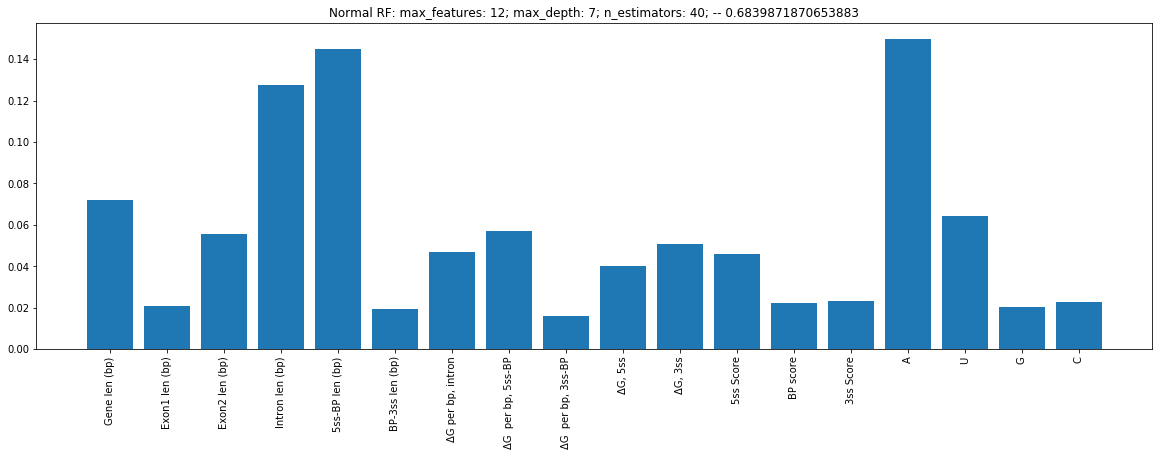

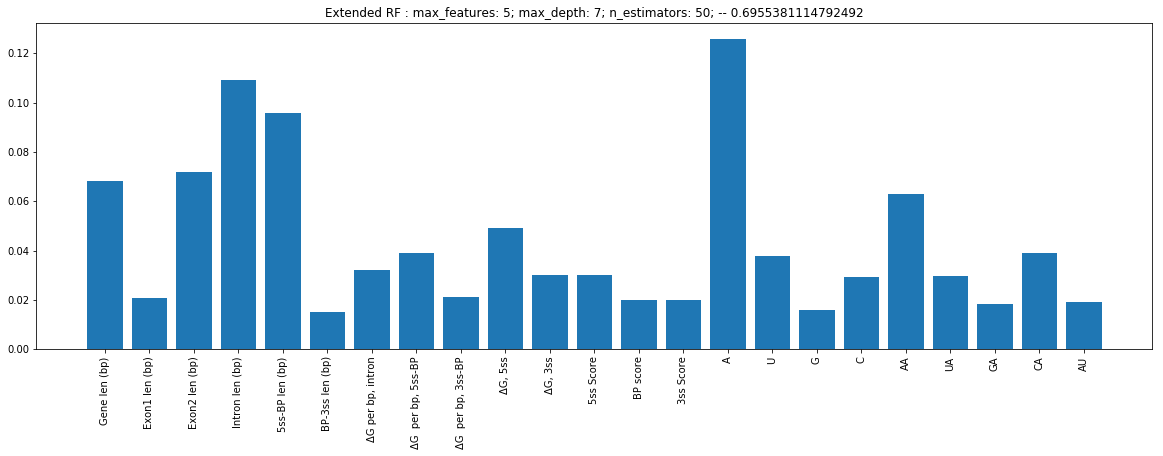

In [15]:
best_RFs(results_1_full,results_2_full,'cut')

Data
Coefficient of determination R^2: 0.46275664633060265
Mean squared error:               0.028019784136156134
Mean absolute error:              0.12495294265262287
Root mean squared error:          0.16739111128180054
Correlation Coefficient:          0.6839871870653882


Extended Data
Coefficient of determination R^2: 0.4617728486705486
Mean squared error:               0.02807109384130203
Mean absolute error:              0.12581442108330096
Root mean squared error:          0.16754430411476848
Correlation Coefficient:          0.6955381114792493


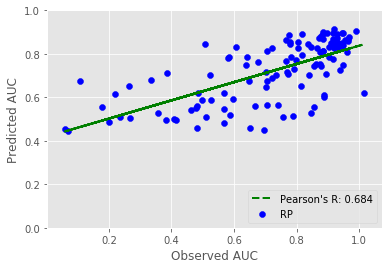

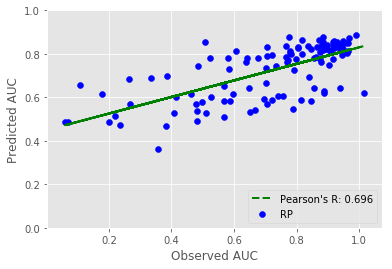

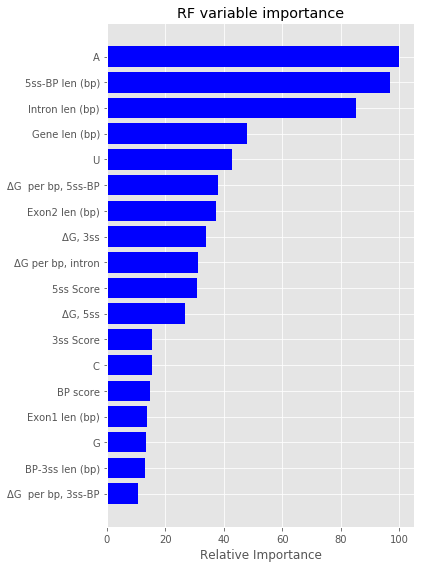

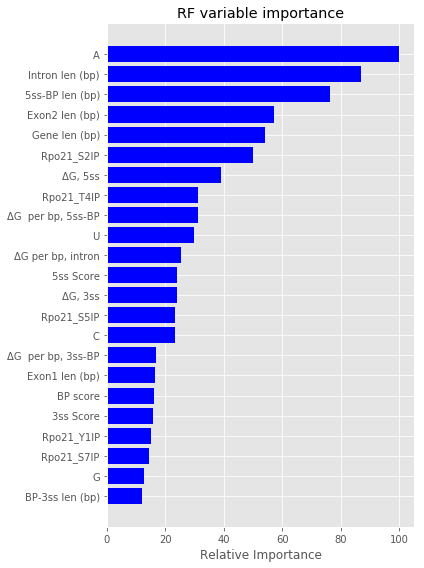

In [76]:
#BEST CUT

# Normal best: 0.6839871870653883 | max_features: 12; max_depth: 7; n_estimators: 40;
# Extended best: 0.695538111479249 | max_features: 5; max_depth: 7; n_estimators: 50;

X,y,X2,y2 = get_data('cut')

rfr1 = ExtraTreesRegressor(n_estimators=40, 
                            criterion='mse', 
                            max_features=12, 
                            max_depth=7, 
                            n_jobs=2,
                            random_state=1337)

rfr2 = ExtraTreesRegressor(n_estimators=50, 
                            criterion='mse', 
                            max_features=5, 
                            max_depth=7, 
                            n_jobs=2,
                            random_state=1337)

kf = KFold(n_splits=5,shuffle=True,random_state=0)
predictions_rfr1 = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2 = cross_val_predict(rfr2,X2,y=y2,cv=kf)

fit_scatter(y,predictions_rfr1)
fit_scatter(y,predictions_rfr2)
print('Data')
print_stats(y,predictions_rfr1)
print('\n')
print('Extended Data')
print_stats(y2,predictions_rfr2)

rfr1.fit(X,y)
rfr2.fit(X2,y2)

names,names2 = get_variable_names('cut')
plot_importance(rfr1.feature_importances_,names,'cut')
plot_importance(rfr2.feature_importances_,names2,'cut_ext')


## MSE Results

Normal best: 0.6839871870653883 | max_features: 12; max_depth: 7; n_estimators: 40;

Extended best: 0.695538111479249 | max_features: 5; max_depth: 7; n_estimators: 50;

Best difference: 0.08235234031060501 | max_features: 12; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.46275664633060276
Mean squared error:               0.02801978413615613
Mean absolute error:              0.1249529426526229
Root mean squared error:          0.16739111128180054
Correlation Coefficient:          0.6839871870653883


Extended feature space
Coefficient of determination R^2: 0.46177284867054846
Mean squared error:               0.028071093841302037
Mean absolute error:              0.12581442108330093
Root mean squared error:          0.1675443041147685
Correlation Coefficient:          0.6955381114792492


# RP Genes

In [ ]:
X,y,X2,y2 = get_data('rp_cut')

mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1_rp = np.zeros((len(mxf),len(md),len(n_est)))
results_2_rp = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est)))
display(f)


i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X2,y=y2,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print_stats(y, predictions_rfr1)
            print('\n')
            print('Extended feature space')
            print_stats(y2, predictions_rfr2)
            print('-------------------------------------------------------\n')
            

            results_1_rp[i][j][k]=np.corrcoef(y, predictions_rfr1)[0][1]
            results_2_rp[i][j][k]=np.corrcoef(y2, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

FloatProgress(value=0.0, max=1008.0)

max_features: 5; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.2200662646993855
Mean squared error:               0.02310306302833034
Mean absolute error:              0.10516115559292183
Root mean squared error:          0.15199691782510047
Correlation Coefficient:          0.47707155767221454


Extended feature space
Coefficient of determination R^2: 0.255714399876972
Mean squared error:               0.022047100096386153
Mean absolute error:              0.10769537900084443
Root mean squared error:          0.14848265924472848
Correlation Coefficient:          0.5259759532794929
-------------------------------------------------------

max_features: 5; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.2698798386815092
Mean squared error:               0.02162749390330484
Mean absolute error:              0.10279348167738833
Root mean squared error:          0.14706289097969222
Correlation Coefficient:

KeyboardInterrupt: 

In [99]:
get_best_settings(results_1_rp,results_2_rp)

NameError: name 'results_1_rp' is not defined

In [100]:
best_RFs(results_1_rp,results_2_rp,'rp_cut')

NameError: name 'best_RFs' is not defined

Data
Coefficient of determination R^2: 0.36032501236987124
Mean squared error:               0.018948342516776955
Mean absolute error:              0.09876138238608177
Root mean squared error:          0.1376529785975478
Correlation Coefficient:          0.6089742911774628


Extended Data
Coefficient of determination R^2: 0.411112065203158
Mean squared error:               0.017443937168573467
Mean absolute error:              0.0956529955848757
Root mean squared error:          0.13207549798722498
Correlation Coefficient:          0.6501022065229568


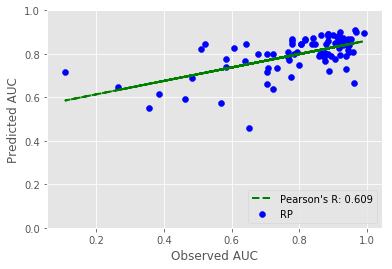

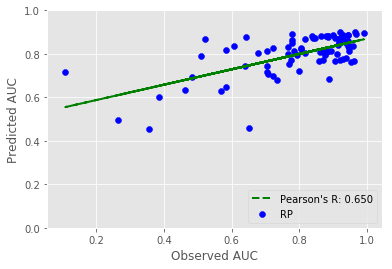

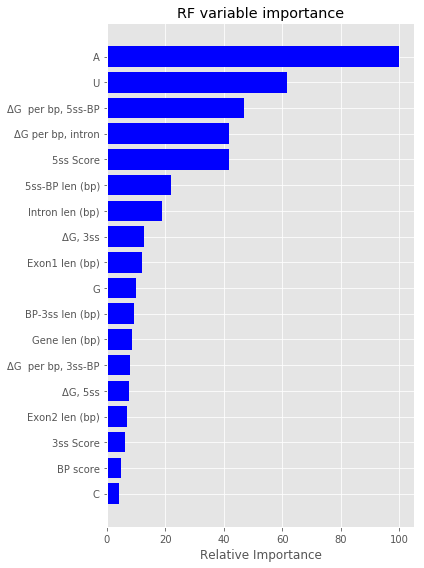

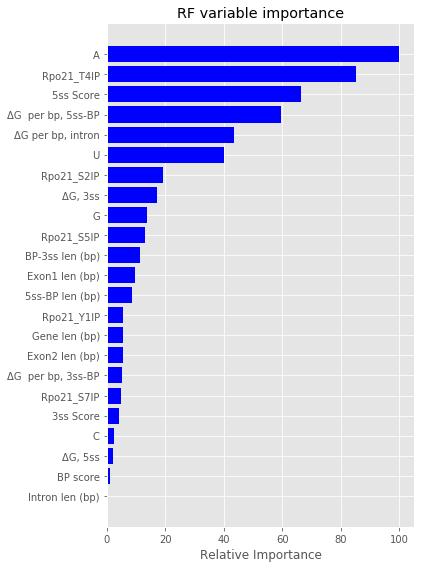

In [79]:
#BEST RIBOSOMAL PROTEIN

# Normal best: 0.6089742911774628 | max_features: 10; max_depth: 5; n_estimators: 40;
# Extended best: 0.6501022065229568 | max_features: 15; max_depth: 5; n_estimators: 10;

X,y,X2,y2 = get_data('rp_cut')

rfr1 = ExtraTreesRegressor(n_estimators=40, 
                            criterion='mse', 
                            max_features=10, 
                            max_depth=5, 
                            n_jobs=2,
                            random_state=1337)

rfr2 = ExtraTreesRegressor(n_estimators=10, 
                            criterion='mse', 
                            max_features=15, 
                            max_depth=5, 
                            n_jobs=2,
                            random_state=1337)

kf = KFold(n_splits=5,shuffle=True,random_state=0)
predictions_rfr1_rp = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2_rp = cross_val_predict(rfr2,X2,y=y2,cv=kf)

fit_scatter(y,predictions_rfr1_rp)
fit_scatter(y,predictions_rfr2_rp)

print('Data')
print_stats(y,predictions_rfr1_rp)
print('\n')
print('Extended Data')
print_stats(y2,predictions_rfr2_rp)

rfr1.fit(X,y)
rfr2.fit(X2,y2)

names,names2 = get_variable_names('cut')
plot_importance(rfr1.feature_importances_,names,'rp_cut')
plot_importance(rfr2.feature_importances_,names2,'rp_cut_extended')

Normal best: 0.683828520812472 | max_features: 80; max_depth: 12; n_estimators: 10;
Extended best: 0.6995253307038448 | max_features: 25; max_depth: 5; n_estimators: 10;
Best difference: 0.178522036722764 | max_features: 7; max_depth: 5; n_estimators: 20;
Normal feature space
Coefficient of determination R^2: 0.3526340326994295
Mean squared error:               0.03376319974358975
Mean absolute error:              0.13876153846153846
Root mean squared error:          0.18374765234851234
Correlation Coefficient:          0.5972822538667238


Extended feature space
Coefficient of determination R^2: 0.32708078033033505
Mean squared error:               0.03509592282051282
Mean absolute error:              0.14166068376068375
Root mean squared error:          0.18733905844887985
Correlation Coefficient:          0.5756356719726347

# Non-RP Genes

In [21]:
X,y,X2,y2 = get_data('nrp_cut')

mxf = [5,7,10,12,15,18,20,25,30,50,80,10]
md = [5,7,10,12,15,18,20]
n_est = [10,20,30,40,50,60,80,90,100,120,140,160]

results_1_nrp = np.zeros((len(mxf),len(md),len(n_est)))
results_2_nrp = np.zeros((len(mxf),len(md),len(n_est)))

f = FloatProgress(min=0, max=(len(mxf)*len(md)*len(n_est)))
display(f)


i = 0
for max_features in mxf:
    j = 0
    for max_depth in md:
        k = 0
        for n_estimators in n_est:            
            
            kf = KFold(n_splits=5,shuffle=True,random_state=0)

            rfr1 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            rfr2 = ExtraTreesRegressor(n_estimators=n_estimators, 
                                        criterion='mse', 
                                        max_features=max_features, 
                                        max_depth=max_depth, 
                                        n_jobs=2,
                                        random_state=1337)

            predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
            predictions_rfr2 = cross_val_predict(rfr2,X=X2,y=y2,cv=kf)
            
            print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))

            print('Normal feature space')
            print_stats(y, predictions_rfr1)
            print('\n')
            print('Extended feature space')
            print_stats(y2, predictions_rfr2)
            print('-------------------------------------------------------\n')
            

            results_1_nrp[i][j][k]=np.corrcoef(y, predictions_rfr1)[0][1]
            results_2_nrp[i][j][k]=np.corrcoef(y2, predictions_rfr2)[0][1]
            
            f.value += 1
            
            k += 1
        j += 1
    i += 1

FloatProgress(value=0.0, max=1008.0)

max_features: 5; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.15972464701057176
Mean squared error:               0.049157302590879186
Mean absolute error:              0.18648199655983744
Root mean squared error:          0.22171446184423602
Correlation Coefficient:          0.40035276150609955


Extended feature space
Coefficient of determination R^2: 0.012279497519927074
Mean squared error:               0.057783053427534065
Mean absolute error:              0.19779515081719623
Root mean squared error:          0.24038105879526794
Correlation Coefficient:          0.21729828187148542
-------------------------------------------------------

max_features: 5; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.21161504302849654
Mean squared error:               0.04612164066227591
Mean absolute error:              0.17846136824244777
Root mean squared error:          0.2147594949292718
Correlation Coeffi

max_features: 5; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.11831044782399724
Mean squared error:               0.05158009211306454
Mean absolute error:              0.18645500131181944
Root mean squared error:          0.22711250981190917
Correlation Coefficient:          0.3543392554813894


Extended feature space
Coefficient of determination R^2: 0.07458708421563609
Mean squared error:               0.05413797103637301
Mean absolute error:              0.1860417426765154
Root mean squared error:          0.23267567779287332
Correlation Coefficient:          0.3051976944114157
-------------------------------------------------------

max_features: 5; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.134492494193859
Mean squared error:               0.050633419397849315
Mean absolute error:              0.18326342096245504
Root mean squared error:          0.2250187089951618
Correlation Coefficient: 

max_features: 5; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.0195530225829319
Mean squared error:               0.057357541872122574
Mean absolute error:              0.1946962481962482
Root mean squared error:          0.23949434622162288
Correlation Coefficient:          0.2676777420952829


Extended feature space
Coefficient of determination R^2: 0.08824580813257776
Mean squared error:               0.0533389162715252
Mean absolute error:              0.18318151875901872
Root mean squared error:          0.2309521947752937
Correlation Coefficient:          0.3257698877578079
-------------------------------------------------------

max_features: 5; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.13646014986307176
Mean squared error:               0.050518308744202226
Mean absolute error:              0.18071129148629148
Root mean squared error:          0.22476278327205823
Correlation Coefficien

max_features: 5; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.005409950521478968
Mean squared error:               0.05818493169191918
Mean absolute error:              0.19759646464646466
Root mean squared error:          0.24121552954136094
Correlation Coefficient:          0.25649078394915426


Extended feature space
Coefficient of determination R^2: 0.07814257018307424
Mean squared error:               0.053929970053198655
Mean absolute error:              0.1888050505050505
Root mean squared error:          0.23222827143394634
Correlation Coefficient:          0.32388260480947345
-------------------------------------------------------

max_features: 5; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.12344885941634365
Mean squared error:               0.0512794877307239
Mean absolute error:              0.18347065656565653
Root mean squared error:          0.2264497465901075
Correlation Coeffic

max_features: 5; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.006107751566960529
Mean squared error:               0.058858733636363625
Mean absolute error:              0.19853636363636365
Root mean squared error:          0.24260818954924754
Correlation Coefficient:          0.24405830609984755


Extended feature space
Coefficient of determination R^2: 0.056307540924813604
Mean squared error:               0.055207350303030304
Mean absolute error:              0.1912060606060606
Root mean squared error:          0.23496244445236414
Correlation Coefficient:          0.2975830894413462
-------------------------------------------------------

max_features: 5; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.1361624070635471
Mean squared error:               0.05053572712121212
Mean absolute error:              0.18189393939393939
Root mean squared error:          0.22480152828931596
Correlation Coef

max_features: 5; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.006107751566960529
Mean squared error:               0.058858733636363625
Mean absolute error:              0.19853636363636365
Root mean squared error:          0.24260818954924754
Correlation Coefficient:          0.24405830609984752


Extended feature space
Coefficient of determination R^2: 0.056307540924813604
Mean squared error:               0.055207350303030304
Mean absolute error:              0.1912060606060606
Root mean squared error:          0.23496244445236414
Correlation Coefficient:          0.2975830894413462
-------------------------------------------------------

max_features: 5; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.136162407063547
Mean squared error:               0.050535727121212126
Mean absolute error:              0.18189393939393939
Root mean squared error:          0.22480152828931596
Correlation Coef

max_features: 5; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.006107751566960529
Mean squared error:               0.058858733636363625
Mean absolute error:              0.19853636363636365
Root mean squared error:          0.24260818954924754
Correlation Coefficient:          0.24405830609984752


Extended feature space
Coefficient of determination R^2: 0.056307540924813715
Mean squared error:               0.0552073503030303
Mean absolute error:              0.1912060606060606
Root mean squared error:          0.23496244445236414
Correlation Coefficient:          0.2975830894413462
-------------------------------------------------------

max_features: 5; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.1361624070635472
Mean squared error:               0.05053572712121211
Mean absolute error:              0.18189393939393939
Root mean squared error:          0.22480152828931593
Correlation Coeffi

max_features: 7; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1317746674052387
Mean squared error:               0.05079241612834069
Mean absolute error:              0.1855422962475235
Root mean squared error:          0.2253717287690288
Correlation Coefficient:          0.3721765787967114


Extended feature space
Coefficient of determination R^2: 0.09034498321771955
Mean squared error:               0.05321611154509304
Mean absolute error:              0.19823766066692008
Root mean squared error:          0.2306861754529149
Correlation Coefficient:          0.34626801195906004
-------------------------------------------------------

max_features: 7; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.1435712467375273
Mean squared error:               0.050102299468710525
Mean absolute error:              0.18668536735991278
Root mean squared error:          0.22383542943133583
Correlation Coefficient: 

max_features: 7; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.0088066071516536
Mean squared error:               0.05798622245074867
Mean absolute error:              0.19965787414605593
Root mean squared error:          0.24080328579724294
Correlation Coefficient:          0.23769386204287307


Extended feature space
Coefficient of determination R^2: 0.07669737438495017
Mean squared error:               0.05401451606171682
Mean absolute error:              0.19931227731864093
Root mean squared error:          0.23241023226552832
Correlation Coefficient:          0.35313600261899225
-------------------------------------------------------

max_features: 7; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.1067201055093061
Mean squared error:               0.052258143614001884
Mean absolute error:              0.1914538970625334
Root mean squared error:          0.22860040160507566
Correlation Coefficien

max_features: 7; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.07001014815859696
Mean squared error:               0.05440572830176767
Mean absolute error:              0.1908992424242424
Root mean squared error:          0.2332503554161658
Correlation Coefficient:          0.3177205895661191


Extended feature space
Coefficient of determination R^2: 0.06476782118602964
Mean squared error:               0.054712411881565656
Mean absolute error:              0.18950934343434342
Root mean squared error:          0.23390684445215718
Correlation Coefficient:          0.3336659258353503
-------------------------------------------------------

max_features: 7; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.12739522685664795
Mean squared error:               0.051048619625753695
Mean absolute error:              0.19166080447330444
Root mean squared error:          0.22593941583033647
Correlation Coeffici

max_features: 7; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.1108390513445544
Mean squared error:               0.05201717942760942
Mean absolute error:              0.1922373737373737
Root mean squared error:          0.22807275029606106
Correlation Coefficient:          0.3642120913046068


Extended feature space
Coefficient of determination R^2: 0.08112560920089718
Mean squared error:               0.05375545803030302
Mean absolute error:              0.18985757575757575
Root mean squared error:          0.23185223317946071
Correlation Coefficient:          0.34610651061137987
-------------------------------------------------------

max_features: 7; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.16093013727245276
Mean squared error:               0.04908677969696969
Mean absolute error:              0.18897171717171715
Root mean squared error:          0.22155536485711577
Correlation Coefficie

max_features: 7; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.12064218071789001
Mean squared error:               0.05144368242424241
Mean absolute error:              0.18978787878787876
Root mean squared error:          0.226811997972423
Correlation Coefficient:          0.37214189477519777


Extended feature space
Coefficient of determination R^2: 0.06702066056081335
Mean squared error:               0.05458061757575757
Mean absolute error:              0.1910848484848485
Root mean squared error:          0.233624950670423
Correlation Coefficient:          0.33458768079205603
-------------------------------------------------------

max_features: 7; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.165255941250939
Mean squared error:               0.048833714015151505
Mean absolute error:              0.1880439393939394
Root mean squared error:          0.2209835152565718
Correlation Coefficient:  

max_features: 7; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.12064218071789001
Mean squared error:               0.05144368242424241
Mean absolute error:              0.18978787878787876
Root mean squared error:          0.226811997972423
Correlation Coefficient:          0.37214189477519777


Extended feature space
Coefficient of determination R^2: 0.06702066056081335
Mean squared error:               0.05458061757575757
Mean absolute error:              0.1910848484848485
Root mean squared error:          0.233624950670423
Correlation Coefficient:          0.3345876807920561
-------------------------------------------------------

max_features: 7; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.165255941250939
Mean squared error:               0.048833714015151505
Mean absolute error:              0.1880439393939394
Root mean squared error:          0.2209835152565718
Correlation Coefficient:   

max_features: 7; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.12064218071789001
Mean squared error:               0.05144368242424241
Mean absolute error:              0.18978787878787876
Root mean squared error:          0.226811997972423
Correlation Coefficient:          0.37214189477519777


Extended feature space
Coefficient of determination R^2: 0.06702066056081335
Mean squared error:               0.05458061757575757
Mean absolute error:              0.1910848484848485
Root mean squared error:          0.233624950670423
Correlation Coefficient:          0.3345876807920561
-------------------------------------------------------

max_features: 7; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.165255941250939
Mean squared error:               0.048833714015151505
Mean absolute error:              0.1880439393939394
Root mean squared error:          0.2209835152565718
Correlation Coefficient:   

max_features: 10; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: -0.03680381022502832
Mean squared error:               0.06065449670192744
Mean absolute error:              0.21247875816523545
Root mean squared error:          0.2462813364872122
Correlation Coefficient:          0.16056953334911422


Extended feature space
Coefficient of determination R^2: 0.025880591658654528
Mean squared error:               0.056987370086631794
Mean absolute error:              0.199867763276286
Root mean squared error:          0.23872027581802052
Correlation Coefficient:          0.24108118379436155
-------------------------------------------------------

max_features: 10; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.08338884991433915
Mean squared error:               0.05362305523139805
Mean absolute error:              0.19681068805587862
Root mean squared error:          0.23156652441878997
Correlation Coeffi

max_features: 10; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.04803208743834941
Mean squared error:               0.055691476095443004
Mean absolute error:              0.20268638845161568
Root mean squared error:          0.23599041526181314
Correlation Coefficient:          0.2920892710768411


Extended feature space
Coefficient of determination R^2: 0.0968823046877898
Mean squared error:               0.05283366894637251
Mean absolute error:              0.19038116522366522
Root mean squared error:          0.22985575682669449
Correlation Coefficient:          0.33812125826429007
-------------------------------------------------------

max_features: 10; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.10571484931507846
Mean squared error:               0.052316952530323424
Mean absolute error:              0.1925806160632297
Root mean squared error:          0.2287289936372812
Correlation Coeffici

max_features: 10; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.06351985365857293
Mean squared error:               0.05478541975589224
Mean absolute error:              0.19381868686868683
Root mean squared error:          0.2340628542846819
Correlation Coefficient:          0.33075743576538197


Extended feature space
Coefficient of determination R^2: 0.01813612708711465
Mean squared error:               0.057440432272727264
Mean absolute error:              0.20424242424242425
Root mean squared error:          0.23966733668301
Correlation Coefficient:          0.2436647213359834
-------------------------------------------------------

max_features: 10; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.11019149107307458
Mean squared error:               0.05205506262398989
Mean absolute error:              0.18857479797979795
Root mean squared error:          0.22815578586568847
Correlation Coeffici

max_features: 10; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.05403958127079955
Mean squared error:               0.055340029166666665
Mean absolute error:              0.1938348484848485
Root mean squared error:          0.2352446155954832
Correlation Coefficient:          0.3173965334173216


Extended feature space
Coefficient of determination R^2: -0.012665473599190902
Mean squared error:               0.05924236969696968
Mean absolute error:              0.20707878787878786
Root mean squared error:          0.24339755482947992
Correlation Coefficient:          0.21729139179621154
-------------------------------------------------------

max_features: 10; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.10563728642172998
Mean squared error:               0.052321490069839
Mean absolute error:              0.1901861742424242
Root mean squared error:          0.228738912452252
Correlation Coefficie

max_features: 10; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.02756477909980848
Mean squared error:               0.05688884272727272
Mean absolute error:              0.1956939393939394
Root mean squared error:          0.23851382083072822
Correlation Coefficient:          0.2964388288864863


Extended feature space
Coefficient of determination R^2: -0.023665879701729287
Mean squared error:               0.05988590909090907
Mean absolute error:              0.2079151515151515
Root mean squared error:          0.24471597637038142
Correlation Coefficient:          0.2065056688191623
-------------------------------------------------------

max_features: 10; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.09289320075385132
Mean squared error:               0.053067037196969695
Mean absolute error:              0.1913409090909091
Root mean squared error:          0.2303628381422874
Correlation Coeffic

max_features: 10; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.02756477909980848
Mean squared error:               0.05688884272727272
Mean absolute error:              0.1956939393939394
Root mean squared error:          0.23851382083072822
Correlation Coefficient:          0.2964388288864863


Extended feature space
Coefficient of determination R^2: -0.023665879701729287
Mean squared error:               0.05988590909090907
Mean absolute error:              0.2079151515151515
Root mean squared error:          0.24471597637038142
Correlation Coefficient:          0.2065056688191623
-------------------------------------------------------

max_features: 10; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.09289320075385132
Mean squared error:               0.053067037196969695
Mean absolute error:              0.19134090909090906
Root mean squared error:          0.2303628381422874
Correlation Coeffi

max_features: 10; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.02756477909980848
Mean squared error:               0.05688884272727272
Mean absolute error:              0.1956939393939394
Root mean squared error:          0.23851382083072822
Correlation Coefficient:          0.29643882888648626


Extended feature space
Coefficient of determination R^2: -0.023665879701729287
Mean squared error:               0.05988590909090908
Mean absolute error:              0.2079151515151515
Root mean squared error:          0.24471597637038142
Correlation Coefficient:          0.2065056688191622
-------------------------------------------------------

max_features: 10; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.09289320075385132
Mean squared error:               0.053067037196969695
Mean absolute error:              0.19134090909090906
Root mean squared error:          0.2303628381422874
Correlation Coeff

max_features: 12; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.08368728843568296
Mean squared error:               0.05360559615367278
Mean absolute error:              0.18768870379620378
Root mean squared error:          0.23152882359151913
Correlation Coefficient:          0.29857969559659175


Extended feature space
Coefficient of determination R^2: 0.017729912726403008
Mean squared error:               0.05746419639025758
Mean absolute error:              0.19479010752072248
Root mean squared error:          0.239716908853459
Correlation Coefficient:          0.2453345460938407
-------------------------------------------------------

max_features: 12; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.06363969579823558
Mean squared error:               0.054778408820367865
Mean absolute error:              0.19165402174447033
Root mean squared error:          0.23404787719688436
Correlation Coeffic

max_features: 12; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.07320307318288977
Mean squared error:               0.0542189376491432
Mean absolute error:              0.18865602175602172
Root mean squared error:          0.23284960306846822
Correlation Coefficient:          0.29796045746700905


Extended feature space
Coefficient of determination R^2: 0.07991345811293504
Mean squared error:               0.05382637059200655
Mean absolute error:              0.18386407708453162
Root mean squared error:          0.2320051089782433
Correlation Coefficient:          0.30936170440519434
-------------------------------------------------------

max_features: 12; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.13864092311944531
Mean squared error:               0.05039073040876222
Mean absolute error:              0.17918134154565968
Root mean squared error:          0.22447879723653685
Correlation Coeffici

max_features: 12; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.10074340533449289
Mean squared error:               0.05260778907003367
Mean absolute error:              0.17581959595959595
Root mean squared error:          0.2293638791746287
Correlation Coefficient:          0.344043921559808


Extended feature space
Coefficient of determination R^2: 0.0016567854328755072
Mean squared error:               0.058404497184680125
Mean absolute error:              0.19297777777777775
Root mean squared error:          0.24167022403407526
Correlation Coefficient:          0.23052316587554023
-------------------------------------------------------

max_features: 12; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.1329227502868262
Mean squared error:               0.05072525164778224
Mean absolute error:              0.17882469696969697
Root mean squared error:          0.22522267125620865
Correlation Coeff

max_features: 12; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.08906465223985516
Mean squared error:               0.05329101272727272
Mean absolute error:              0.1779090909090909
Root mean squared error:          0.23084846269202816
Correlation Coefficient:          0.3304498448040121


Extended feature space
Coefficient of determination R^2: -0.005918437337775639
Mean squared error:               0.05884765848484848
Mean absolute error:              0.1952939393939394
Root mean squared error:          0.24258536329475544
Correlation Coefficient:          0.21948090246859298
-------------------------------------------------------

max_features: 12; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.1283630472401226
Mean squared error:               0.050992000757575755
Mean absolute error:              0.18017272727272726
Root mean squared error:          0.22581408449779158
Correlation Coeff

max_features: 12; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.10253780841001447
Mean squared error:               0.052502813939393926
Mean absolute error:              0.17695151515151514
Root mean squared error:          0.22913492518469097
Correlation Coefficient:          0.34348839958737787


Extended feature space
Coefficient of determination R^2: -0.016550253588055286
Mean squared error:               0.05946963484848484
Mean absolute error:              0.19609393939393938
Root mean squared error:          0.24386396791753562
Correlation Coefficient:          0.20527731160063362
-------------------------------------------------------

max_features: 12; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.14207587772113184
Mean squared error:               0.05018978068181818
Mean absolute error:              0.178780303030303
Root mean squared error:          0.22403075833871156
Correlation Coe

max_features: 12; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.10253780841001436
Mean squared error:               0.05250281393939393
Mean absolute error:              0.17695151515151517
Root mean squared error:          0.22913492518469097
Correlation Coefficient:          0.3434883995873777


Extended feature space
Coefficient of determination R^2: -0.016550253588055286
Mean squared error:               0.059469634848484845
Mean absolute error:              0.19609393939393938
Root mean squared error:          0.24386396791753562
Correlation Coefficient:          0.20527731160063342
-------------------------------------------------------

max_features: 12; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.14207587772113184
Mean squared error:               0.05018978068181818
Mean absolute error:              0.178780303030303
Root mean squared error:          0.22403075833871156
Correlation Coef

max_features: 12; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.10253780841001436
Mean squared error:               0.05250281393939393
Mean absolute error:              0.17695151515151517
Root mean squared error:          0.22913492518469097
Correlation Coefficient:          0.34348839958737776


Extended feature space
Coefficient of determination R^2: -0.016550253588055286
Mean squared error:               0.05946963484848484
Mean absolute error:              0.19609393939393938
Root mean squared error:          0.24386396791753562
Correlation Coefficient:          0.20527731160063348
-------------------------------------------------------

max_features: 12; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.14207587772113184
Mean squared error:               0.05018978068181818
Mean absolute error:              0.178780303030303
Root mean squared error:          0.22403075833871156
Correlation Coef

max_features: 15; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.06532257453370016
Mean squared error:               0.05467995802215192
Mean absolute error:              0.19218400217627485
Root mean squared error:          0.23383746069043754
Correlation Coefficient:          0.32610797892933907


Extended feature space
Coefficient of determination R^2: -0.027316616197899712
Mean squared error:               0.06009948236541172
Mean absolute error:              0.20566741004366001
Root mean squared error:          0.24515195770258846
Correlation Coefficient:          0.2014055099474954
-------------------------------------------------------

max_features: 15; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.0862092207766767
Mean squared error:               0.05345805952682909
Mean absolute error:              0.1912529613547227
Root mean squared error:          0.23120999011035204
Correlation Coeffic

max_features: 15; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.08857056202033076
Mean squared error:               0.053319917707458024
Mean absolute error:              0.19050414862914863
Root mean squared error:          0.23091106016702193
Correlation Coefficient:          0.34819908969377766


Extended feature space
Coefficient of determination R^2: -0.07934861659752035
Mean squared error:               0.06314342835163307
Mean absolute error:              0.19661916305916308
Root mean squared error:          0.25128356164228705
Correlation Coefficient:          0.133319244915854
-------------------------------------------------------

max_features: 15; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.09300877063500912
Mean squared error:               0.05306027619464081
Mean absolute error:              0.19020416404302767
Root mean squared error:          0.23034816299384897
Correlation Coeffi

max_features: 15; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.082874016599912
Mean squared error:               0.053653173712121215
Mean absolute error:              0.19011767676767674
Root mean squared error:          0.23163154731625227
Correlation Coefficient:          0.337218722831604


Extended feature space
Coefficient of determination R^2: -0.12956438152353478
Mean squared error:               0.06608112198089225
Mean absolute error:              0.21110005050505046
Root mean squared error:          0.25706248652981684
Correlation Coefficient:          0.06526892854604346
-------------------------------------------------------

max_features: 15; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.08328467153776498
Mean squared error:               0.053629149814515914
Mean absolute error:              0.1889123665223665
Root mean squared error:          0.23157968350983624
Correlation Coeffi

max_features: 15; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.10450739536078713
Mean squared error:               0.0523875903030303
Mean absolute error:              0.18616969696969699
Root mean squared error:          0.22888335523368733
Correlation Coefficient:          0.36239934577259675


Extended feature space
Coefficient of determination R^2: -0.09373774864362505
Mean squared error:               0.06398521303030302
Mean absolute error:              0.2076030303030303
Root mean squared error:          0.25295298581021536
Correlation Coefficient:          0.10960863289304816
-------------------------------------------------------

max_features: 15; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.11042826482848733
Mean squared error:               0.05204121102272728
Mean absolute error:              0.18520757575757577
Root mean squared error:          0.2281254282685893
Correlation Coeffi

max_features: 15; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.11432922352290553
Mean squared error:               0.05181299939393939
Mean absolute error:              0.1849878787878788
Root mean squared error:          0.22762468977230785
Correlation Coefficient:          0.3706182349578913


Extended feature space
Coefficient of determination R^2: -0.07984723923734083
Mean squared error:               0.06317259848484846
Mean absolute error:              0.2064212121212121
Root mean squared error:          0.2513415972035836
Correlation Coefficient:          0.12640246074747477
-------------------------------------------------------

max_features: 15; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.10935625319268893
Mean squared error:               0.05210392522727274
Mean absolute error:              0.18474696969696972
Root mean squared error:          0.22826284241477574
Correlation Coeffic

max_features: 15; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.11432922352290564
Mean squared error:               0.051812999393939387
Mean absolute error:              0.1849878787878788
Root mean squared error:          0.22762468977230785
Correlation Coefficient:          0.37061823495789137


Extended feature space
Coefficient of determination R^2: -0.07984723923734083
Mean squared error:               0.06317259848484846
Mean absolute error:              0.2064212121212121
Root mean squared error:          0.2513415972035836
Correlation Coefficient:          0.12640246074747477
-------------------------------------------------------

max_features: 15; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.11199981884549326
Mean squared error:               0.05194927287878789
Mean absolute error:              0.18394545454545455
Root mean squared error:          0.22792383130947033
Correlation Coeff

max_features: 15; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.11432922352290564
Mean squared error:               0.051812999393939387
Mean absolute error:              0.1849878787878788
Root mean squared error:          0.22762468977230785
Correlation Coefficient:          0.37061823495789137


Extended feature space
Coefficient of determination R^2: -0.07984723923734083
Mean squared error:               0.06317259848484846
Mean absolute error:              0.2064212121212121
Root mean squared error:          0.2513415972035836
Correlation Coefficient:          0.12640246074747477
-------------------------------------------------------

max_features: 15; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.11199981884549326
Mean squared error:               0.05194927287878789
Mean absolute error:              0.18394545454545455
Root mean squared error:          0.22792383130947033
Correlation Coeff

max_features: 18; max_depth: 5; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.15657073618404493
Mean squared error:               0.049341810857476145
Mean absolute error:              0.18456672079603897
Root mean squared error:          0.2221301664733454
Correlation Coefficient:          0.427552486041203


Extended feature space
Coefficient of determination R^2: 0.12630945884738853
Mean squared error:               0.05111213859770114
Mean absolute error:              0.182673606023606
Root mean squared error:          0.22607993851224645
Correlation Coefficient:          0.3565204940658726
-------------------------------------------------------

max_features: 18; max_depth: 5; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.161458207324646
Mean squared error:               0.04905588684827135
Mean absolute error:              0.17958018871700687
Root mean squared error:          0.22148563576058686
Correlation Coefficient: 

max_features: 18; max_depth: 7; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.15013021848187125
Mean squared error:               0.04971859029816938
Mean absolute error:              0.17686935185185185
Root mean squared error:          0.22297665863979885
Correlation Coefficient:          0.4141637606219859


Extended feature space
Coefficient of determination R^2: 0.11338426132201951
Mean squared error:               0.051868281025943284
Mean absolute error:              0.1838354632909178
Root mean squared error:          0.22774608893665613
Correlation Coefficient:          0.3636031875641514
-------------------------------------------------------

max_features: 18; max_depth: 7; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.1252836023852837
Mean squared error:               0.05117215265897652
Mean absolute error:              0.18565263429752066
Root mean squared error:          0.22621262709887907
Correlation Coefficie

max_features: 18; max_depth: 10; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.21131104831998615
Mean squared error:               0.04613942478484848
Mean absolute error:              0.1697221212121212
Root mean squared error:          0.21480089567980967
Correlation Coefficient:          0.47451673860875887


Extended feature space
Coefficient of determination R^2: 0.08943501651157171
Mean squared error:               0.053269345890909085
Mean absolute error:              0.18956121212121207
Root mean squared error:          0.23080152922134006
Correlation Coefficient:          0.3366636978422237
-------------------------------------------------------

max_features: 18; max_depth: 10; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.16722682951369183
Mean squared error:               0.048718414250187234
Mean absolute error:              0.1790590404040404
Root mean squared error:          0.22072248243028447
Correlation Coeff

max_features: 18; max_depth: 12; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.21833749006875858
Mean squared error:               0.045728367954545455
Mean absolute error:              0.16819242424242423
Root mean squared error:          0.21384192281810752
Correlation Coefficient:          0.48105718728540303


Extended feature space
Coefficient of determination R^2: 0.09416127017421727
Mean squared error:               0.052992853333333326
Mean absolute error:              0.19018181818181815
Root mean squared error:          0.23020176657300725
Correlation Coefficient:          0.3380537889466864
-------------------------------------------------------

max_features: 18; max_depth: 12; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.1653748299129073
Mean squared error:               0.0488267588594276
Mean absolute error:              0.17877373737373736
Root mean squared error:          0.22096777787593286
Correlation Coeff

max_features: 18; max_depth: 15; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.21993771666022466
Mean squared error:               0.04563475242424243
Mean absolute error:              0.1681424242424243
Root mean squared error:          0.21362292111157555
Correlation Coefficient:          0.4827552257052628


Extended feature space
Coefficient of determination R^2: 0.09416127017421727
Mean squared error:               0.052992853333333326
Mean absolute error:              0.19018181818181815
Root mean squared error:          0.23020176657300725
Correlation Coefficient:          0.3380537889466864
-------------------------------------------------------

max_features: 18; max_depth: 15; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.17170556438175588
Mean squared error:               0.0484564018939394
Mean absolute error:              0.17721969696969697
Root mean squared error:          0.22012814879960127
Correlation Coeffic

max_features: 18; max_depth: 18; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.21993771666022466
Mean squared error:               0.04563475242424243
Mean absolute error:              0.1681424242424243
Root mean squared error:          0.21362292111157555
Correlation Coefficient:          0.4827552257052628


Extended feature space
Coefficient of determination R^2: 0.09416127017421716
Mean squared error:               0.05299285333333333
Mean absolute error:              0.19018181818181817
Root mean squared error:          0.23020176657300728
Correlation Coefficient:          0.3380537889466864
-------------------------------------------------------

max_features: 18; max_depth: 18; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.1717055643817561
Mean squared error:               0.048456401893939384
Mean absolute error:              0.17721969696969697
Root mean squared error:          0.22012814879960124
Correlation Coeffic

max_features: 18; max_depth: 20; n_estimators: 10;

Normal feature space
Coefficient of determination R^2: 0.21993771666022466
Mean squared error:               0.04563475242424243
Mean absolute error:              0.16814242424242426
Root mean squared error:          0.21362292111157555
Correlation Coefficient:          0.4827552257052628


Extended feature space
Coefficient of determination R^2: 0.09416127017421727
Mean squared error:               0.052992853333333326
Mean absolute error:              0.19018181818181815
Root mean squared error:          0.23020176657300725
Correlation Coefficient:          0.3380537889466864
-------------------------------------------------------

max_features: 18; max_depth: 20; n_estimators: 20;

Normal feature space
Coefficient of determination R^2: 0.171705564381756
Mean squared error:               0.04845640189393939
Mean absolute error:              0.17721969696969697
Root mean squared error:          0.22012814879960124
Correlation Coeffic

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f79ed628ae0, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/ghristov/miniconda3/envs/mlp/lib/python3.5...ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/ghrist.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f79ed628ae0, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/ghristov/miniconda3/envs/mlp/lib/python3.5...ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/ghrist.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "X,y,X2,y2 = get_data('nrp_cut')\n\nmxf = [5,7,10,1...    \n            k += 1\n        j += 1\n    i += 1", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 28, 16, 1, 2, 438848, tzinfo=tzutc()), 'msg_id': '7f39c4057a024e4d8b63d7bde59a5d95', 'msg_type': 'execute_request', 'session': '688c6bb77c35485b9048d72f0683fe03', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '7f39c4057a024e4d8b63d7bde59a5d95', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'688c6bb77c35485b9048d72f0683fe03']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "X,y,X2,y2 = get_data('nrp_cut')\n\nmxf = [5,7,10,1...    \n            k += 1\n        j += 1\n    i += 1", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 28, 16, 1, 2, 438848, tzinfo=tzutc()), 'msg_id': '7f39c4057a024e4d8b63d7bde59a5d95', 'msg_type': 'execute_request', 'session': '688c6bb77c35485b9048d72f0683fe03', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '7f39c4057a024e4d8b63d7bde59a5d95', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'688c6bb77c35485b9048d72f0683fe03'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "X,y,X2,y2 = get_data('nrp_cut')\n\nmxf = [5,7,10,1...    \n            k += 1\n        j += 1\n    i += 1", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 28, 16, 1, 2, 438848, tzinfo=tzutc()), 'msg_id': '7f39c4057a024e4d8b63d7bde59a5d95', 'msg_type': 'execute_request', 'session': '688c6bb77c35485b9048d72f0683fe03', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '7f39c4057a024e4d8b63d7bde59a5d95', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="X,y,X2,y2 = get_data('nrp_cut')\n\nmxf = [5,7,10,1...    \n            k += 1\n        j += 1\n    i += 1", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "X,y,X2,y2 = get_data('nrp_cut')\n\nmxf = [5,7,10,1...    \n            k += 1\n        j += 1\n    i += 1"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("X,y,X2,y2 = get_data('nrp_cut')\n\nmxf = [5,7,10,1...    \n            k += 1\n        j += 1\n    i += 1",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("X,y,X2,y2 = get_data('nrp_cut')\n\nmxf = [5,7,10,1...    \n            k += 1\n        j += 1\n    i += 1",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="X,y,X2,y2 = get_data('nrp_cut')\n\nmxf = [5,7,10,1...    \n            k += 1\n        j += 1\n    i += 1", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.For object>], cell_name='<ipython-input-21-d3d30e8a57e5>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f799d2544a8, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f79a7849d20, file "<ipython-input-21-d3d30e8a57e5>", line 15>
        result = <ExecutionResult object at 7f799d2544a8, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f79a7849d20, file "<ipython-input-21-d3d30e8a57e5>", line 15>, result=<ExecutionResult object at 7f799d2544a8, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f79a7849d20, file "<ipython-input-21-d3d30e8a57e5>", line 15>
        self.user_global_ns = {'DecisionTreeRegressor': <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 'ExtraTreesRegressor': <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, 'FloatProgress': <class 'ipywidgets.widgets.widget_float.FloatProgress'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'In': ['', "from __future__ import print_function, division\n..._ipython().run_line_magic('matplotlib', 'inline')", "def fit_scatter(y_true, y_pred):\n    assert y_tr....set_ylabel('Predicted AUC')\n    ax.set_title('')", "def print_stats(true,predictions):\n    print('Co...{}'.format(np.corrcoef(true, predictions)[0][1]))", 'def get_best_settings(results_1,results_2):\n    ...t_k_1],mxf[best_i_2],md[best_j_2],n_est[best_k_2]', "data_path = os.path.join(os.getcwd(), 'datasets'...res_cut.shape[0],extended_features_cut.shape[1]))", 'def get_data(dataset):\n    \n    X = gene_feature...d\n    else:\n        return None, None, None, None', 'kf = KFold(n_splits=5,shuffle=True,random_state=0)', "X,y,X2,y2 = get_data('cut')\n\nlr1 = LinearRegress...int('Extended Data')\nprint_stats(y2,predictions2)", 'def get_data(dataset):\n    \n    X = gene_feature...d\n    else:\n        return None, None, None, None', "X,y,X2,y2 = get_data('cut')\n\nlr1 = LinearRegress...int('Extended Data')\nprint_stats(y2,predictions2)", "X,y,X2,y2 = get_data('cut')\n\nrfr1 = ExtraTreesRe...forrest regression extended features importance')", 'def best_RFs(results1,results2,dataset):\n     \n ...ettings,np.corrcoef(y2, predictions_rfr2)[0][1]))', "X,y,X2,y2 = get_data('cut')\nprint('echo')\nmxf = ...    \n            k += 1\n        j += 1\n    i += 1", 'get_best_settings(results_1_full,results_2_full)', "best_RFs(results_1_full,results_2_full,'cut')", "X,y,X2,y2 = get_data('rp_cut')\n\nmxf = [5,7,10,12...    \n            k += 1\n        j += 1\n    i += 1", 'get_best_settings(results_1_rp,results_2_rp)', "best_RFs(results_1_rp,results_2_rp,'rp_cut')", 'def best_RFs(results1,results2,dataset):\n     \n ...ettings,np.corrcoef(y2, predictions_rfr2)[0][1]))', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Lasso': <class 'sklearn.linear_model.coordinate_descent.Lasso'>, 'LassoCV': <class 'sklearn.linear_model.coordinate_descent.LassoCV'>, ...}
        self.user_ns = {'DecisionTreeRegressor': <class 'sklearn.tree.tree.DecisionTreeRegressor'>, 'ExtraTreesRegressor': <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, 'FloatProgress': <class 'ipywidgets.widgets.widget_float.FloatProgress'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'In': ['', "from __future__ import print_function, division\n..._ipython().run_line_magic('matplotlib', 'inline')", "def fit_scatter(y_true, y_pred):\n    assert y_tr....set_ylabel('Predicted AUC')\n    ax.set_title('')", "def print_stats(true,predictions):\n    print('Co...{}'.format(np.corrcoef(true, predictions)[0][1]))", 'def get_best_settings(results_1,results_2):\n    ...t_k_1],mxf[best_i_2],md[best_j_2],n_est[best_k_2]', "data_path = os.path.join(os.getcwd(), 'datasets'...res_cut.shape[0],extended_features_cut.shape[1]))", 'def get_data(dataset):\n    \n    X = gene_feature...d\n    else:\n        return None, None, None, None', 'kf = KFold(n_splits=5,shuffle=True,random_state=0)', "X,y,X2,y2 = get_data('cut')\n\nlr1 = LinearRegress...int('Extended Data')\nprint_stats(y2,predictions2)", 'def get_data(dataset):\n    \n    X = gene_feature...d\n    else:\n        return None, None, None, None', "X,y,X2,y2 = get_data('cut')\n\nlr1 = LinearRegress...int('Extended Data')\nprint_stats(y2,predictions2)", "X,y,X2,y2 = get_data('cut')\n\nrfr1 = ExtraTreesRe...forrest regression extended features importance')", 'def best_RFs(results1,results2,dataset):\n     \n ...ettings,np.corrcoef(y2, predictions_rfr2)[0][1]))', "X,y,X2,y2 = get_data('cut')\nprint('echo')\nmxf = ...    \n            k += 1\n        j += 1\n    i += 1", 'get_best_settings(results_1_full,results_2_full)', "best_RFs(results_1_full,results_2_full,'cut')", "X,y,X2,y2 = get_data('rp_cut')\n\nmxf = [5,7,10,12...    \n            k += 1\n        j += 1\n    i += 1", 'get_best_settings(results_1_rp,results_2_rp)', "best_RFs(results_1_rp,results_2_rp,'rp_cut')", 'def best_RFs(results1,results2,dataset):\n     \n ...ettings,np.corrcoef(y2, predictions_rfr2)[0][1]))', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'KMeans': <class 'sklearn.cluster.k_means_.KMeans'>, 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Lasso': <class 'sklearn.linear_model.coordinate_descent.Lasso'>, 'LassoCV': <class 'sklearn.linear_model.coordinate_descent.LassoCV'>, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/ghristov/Random-forest-regression-on-mRNA-data/<ipython-input-21-d3d30e8a57e5> in <module>()
     32                                         max_features=max_features, 
     33                                         max_depth=max_depth, 
     34                                         n_jobs=2,
     35                                         random_state=1337)
     36 
---> 37             predictions_rfr1 = cross_val_predict(rfr1,X=X,y=y,cv=kf)
     38             predictions_rfr2 = cross_val_predict(rfr2,X=X2,y=y2,cv=kf)
     39             
     40             print('max_features: {}; max_depth: {}; n_estimators: {};\n'.format(max_features,max_depth,n_estimators))
     41 

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in cross_val_predict(estimator=ExtraTreesRegressor(bootstrap=False, criterion='..., random_state=1337, verbose=0, warm_start=False), X=    Gene len (bp)  Exon1 len (bp)  Exon2 len (bp...  0.160  0.218  
32  0.301  0.308  0.158  0.233  , y=0     0.481
1     0.235
2     0.740
3     0.856
...31    0.666
32    0.201
Name: AUC, dtype: float64, groups=None, cv=KFold(n_splits=5, random_state=0, shuffle=True), n_jobs=1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', method='predict')
    675     # independent, and that it is pickle-able.
    676     parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
    677                         pre_dispatch=pre_dispatch)
    678     prediction_blocks = parallel(delayed(_fit_and_predict)(
    679         clone(estimator), X, y, train, test, verbose, fit_params, method)
--> 680         for train, test in cv.split(X, y, groups))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=5, random_state=0, shuffle=True)>
        X =     Gene len (bp)  Exon1 len (bp)  Exon2 len (bp...  0.160  0.218  
32  0.301  0.308  0.158  0.233  
        y = 0     0.481
1     0.235
2     0.740
3     0.856
...31    0.666
32    0.201
Name: AUC, dtype: float64
        groups = None
    681 
    682     # Concatenate the predictions
    683     predictions = [pred_block_i for pred_block_i, _ in prediction_blocks]
    684     test_indices = np.concatenate([indices_i

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=1), iterable=<generator object cross_val_predict.<locals>.<genexpr>>)
    774         self.n_completed_tasks = 0
    775         try:
    776             # Only set self._iterating to True if at least a batch
    777             # was dispatched. In particular this covers the edge
    778             # case of Parallel used with an exhausted iterator.
--> 779             while self.dispatch_one_batch(iterator):
        self.dispatch_one_batch = <bound method Parallel.dispatch_one_batch of Parallel(n_jobs=1)>
        iterator = <generator object cross_val_predict.<locals>.<genexpr>>
    780                 self._iterating = True
    781             else:
    782                 self._iterating = False
    783 

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in dispatch_one_batch(self=Parallel(n_jobs=1), iterator=<generator object cross_val_predict.<locals>.<genexpr>>)
    620             tasks = BatchedCalls(itertools.islice(iterator, batch_size))
    621             if len(tasks) == 0:
    622                 # No more tasks available in the iterator: tell caller to stop.
    623                 return False
    624             else:
--> 625                 self._dispatch(tasks)
        self._dispatch = <bound method Parallel._dispatch of Parallel(n_jobs=1)>
        tasks = <sklearn.externals.joblib.parallel.BatchedCalls object>
    626                 return True
    627 
    628     def _print(self, msg, msg_args):
    629         """Display the message on stout or stderr depending on verbosity"""

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in _dispatch(self=Parallel(n_jobs=1), batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    583         self.n_dispatched_tasks += len(batch)
    584         self.n_dispatched_batches += 1
    585 
    586         dispatch_timestamp = time.time()
    587         cb = BatchCompletionCallBack(dispatch_timestamp, len(batch), self)
--> 588         job = self._backend.apply_async(batch, callback=cb)
        job = undefined
        self._backend.apply_async = <bound method SequentialBackend.apply_async of <...lib._parallel_backends.SequentialBackend object>>
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
        cb = <sklearn.externals.joblib.parallel.BatchCompletionCallBack object>
    589         self._jobs.append(job)
    590 
    591     def dispatch_next(self):
    592         """Dispatch more data for parallel processing

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/externals/joblib/_parallel_backends.py in apply_async(self=<sklearn.externals.joblib._parallel_backends.SequentialBackend object>, func=<sklearn.externals.joblib.parallel.BatchedCalls object>, callback=<sklearn.externals.joblib.parallel.BatchCompletionCallBack object>)
    106             raise ValueError('n_jobs == 0 in Parallel has no meaning')
    107         return 1
    108 
    109     def apply_async(self, func, callback=None):
    110         """Schedule a func to be run"""
--> 111         result = ImmediateResult(func)
        result = undefined
        func = <sklearn.externals.joblib.parallel.BatchedCalls object>
    112         if callback:
    113             callback(result)
    114         return result
    115 

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/externals/joblib/_parallel_backends.py in __init__(self=<sklearn.externals.joblib._parallel_backends.ImmediateResult object>, batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    327 
    328 class ImmediateResult(object):
    329     def __init__(self, batch):
    330         # Don't delay the application, to avoid keeping the input
    331         # arguments in memory
--> 332         self.results = batch()
        self.results = undefined
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
    333 
    334     def get(self):
    335         return self.results
    336 

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_predict>, (ExtraTreesRegressor(bootstrap=False, criterion='..., random_state=1337, verbose=0, warm_start=False),     Gene len (bp)  Exon1 len (bp)  Exon2 len (bp...  0.160  0.218  
32  0.301  0.308  0.158  0.233  , 0     0.481
1     0.235
2     0.740
3     0.856
...31    0.666
32    0.201
Name: AUC, dtype: float64, array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 1..., 19,
       21, 22, 23, 27, 28, 29, 30, 31, 32]), array([ 2, 11, 17, 20, 24, 25, 26]), 0, None, 'predict'), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_predict>
        args = (ExtraTreesRegressor(bootstrap=False, criterion='..., random_state=1337, verbose=0, warm_start=False),     Gene len (bp)  Exon1 len (bp)  Exon2 len (bp...  0.160  0.218  
32  0.301  0.308  0.158  0.233  , 0     0.481
1     0.235
2     0.740
3     0.856
...31    0.666
32    0.201
Name: AUC, dtype: float64, array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 1..., 19,
       21, 22, 23, 27, 28, 29, 30, 31, 32]), array([ 2, 11, 17, 20, 24, 25, 26]), 0, None, 'predict')
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _fit_and_predict(estimator=ExtraTreesRegressor(bootstrap=False, criterion='..., random_state=1337, verbose=0, warm_start=False), X=    Gene len (bp)  Exon1 len (bp)  Exon2 len (bp...  0.160  0.218  
32  0.301  0.308  0.158  0.233  , y=0     0.481
1     0.235
2     0.740
3     0.856
...31    0.666
32    0.201
Name: AUC, dtype: float64, train=array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 1..., 19,
       21, 22, 23, 27, 28, 29, 30, 31, 32]), test=array([ 2, 11, 17, 20, 24, 25, 26]), verbose=0, fit_params={}, method='predict')
    748     X_test, _ = _safe_split(estimator, X, y, test, train)
    749 
    750     if y_train is None:
    751         estimator.fit(X_train, **fit_params)
    752     else:
--> 753         estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of ExtraTreesRegres... random_state=1337, verbose=0, warm_start=False)>
        X_train =     Gene len (bp)  Exon1 len (bp)  Exon2 len (bp...  0.160  0.218  
32  0.301  0.308  0.158  0.233  
        y_train = 0     0.481
1     0.235
3     0.856
4     0.499
...31    0.666
32    0.201
Name: AUC, dtype: float64
        fit_params = {}
    754     func = getattr(estimator, method)
    755     predictions = func(X_test)
    756     if method in ['decision_function', 'predict_proba', 'predict_log_proba']:
    757         n_classes = len(set(y))

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/ensemble/forest.py in fit(self=ExtraTreesRegressor(bootstrap=False, criterion='..., random_state=1337, verbose=0, warm_start=False), X=array([[ 1.4370e+03,  1.0000e+01,  1.1180e+03,  ...0e-01,  1.5800e-01,  2.3300e-01]], dtype=float32), y=array([[0.481],
       [0.235],
       [0.856],
...
       [0.06 ],
       [0.666],
       [0.201]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 9
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Mar 28 17:24:05 2018
PID: 17417      Python 3.5.4: /home/ghristov/miniconda3/envs/mlp/bin/python
...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (ExtraTreeRegressor(criterion='mse', max_depth=5,...om_state=1125387415,
          splitter='random'), ExtraTreesRegressor(bootstrap=False, criterion='..., random_state=1337, verbose=0, warm_start=False), array([[ 1.4370e+03,  1.0000e+01,  1.1180e+03,  ...0e-01,  1.5800e-01,  2.3300e-01]], dtype=float32), array([[0.481],
       [0.235],
       [0.856],
...
       [0.06 ],
       [0.666],
       [0.201]]), None, 0, 10), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (ExtraTreeRegressor(criterion='mse', max_depth=5,...om_state=1125387415,
          splitter='random'), ExtraTreesRegressor(bootstrap=False, criterion='..., random_state=1337, verbose=0, warm_start=False), array([[ 1.4370e+03,  1.0000e+01,  1.1180e+03,  ...0e-01,  1.5800e-01,  2.3300e-01]], dtype=float32), array([[0.481],
       [0.235],
       [0.856],
...
       [0.06 ],
       [0.666],
       [0.201]]), None, 0, 10)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/ensemble/forest.py in _parallel_build_trees(tree=ExtraTreeRegressor(criterion='mse', max_depth=5,...om_state=1125387415,
          splitter='random'), forest=ExtraTreesRegressor(bootstrap=False, criterion='..., random_state=1337, verbose=0, warm_start=False), X=array([[ 1.4370e+03,  1.0000e+01,  1.1180e+03,  ...0e-01,  1.5800e-01,  2.3300e-01]], dtype=float32), y=array([[0.481],
       [0.235],
       [0.856],
...
       [0.06 ],
       [0.666],
       [0.201]]), sample_weight=None, tree_idx=0, n_trees=10, verbose=0, class_weight=None)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
    121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
    122     else:
--> 123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeRegressor.fit of Extra...m_state=1125387415,
          splitter='random')>
        X = array([[ 1.4370e+03,  1.0000e+01,  1.1180e+03,  ...0e-01,  1.5800e-01,  2.3300e-01]], dtype=float32)
        y = array([[0.481],
       [0.235],
       [0.856],
...
       [0.06 ],
       [0.666],
       [0.201]])
        sample_weight = None
    124 
    125     return tree
    126 
    127 

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/tree/tree.py in fit(self=ExtraTreeRegressor(criterion='mse', max_depth=5,...om_state=1125387415,
          splitter='random'), X=array([[ 1.4370e+03,  1.0000e+01,  1.1180e+03,  ...0e-01,  1.5800e-01,  2.3300e-01]], dtype=float32), y=array([[0.481],
       [0.235],
       [0.856],
...
       [0.06 ],
       [0.666],
       [0.201]]), sample_weight=None, check_input=False, X_idx_sorted=None)
   1119 
   1120         super(DecisionTreeRegressor, self).fit(
   1121             X, y,
   1122             sample_weight=sample_weight,
   1123             check_input=check_input,
-> 1124             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
   1125         return self
   1126 
   1127 
   1128 class ExtraTreeClassifier(DecisionTreeClassifier):

...........................................................................
/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/tree/tree.py in fit(self=ExtraTreeRegressor(criterion='mse', max_depth=5,...om_state=1125387415,
          splitter='random'), X=array([[ 1.4370e+03,  1.0000e+01,  1.1180e+03,  ...0e-01,  1.5800e-01,  2.3300e-01]], dtype=float32), y=array([[0.481],
       [0.235],
       [0.856],
...
       [0.06 ],
       [0.666],
       [0.201]]), sample_weight=None, check_input=False, X_idx_sorted=None)
    237         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
    238             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    239         if max_depth <= 0:
    240             raise ValueError("max_depth must be greater than zero. ")
    241         if not (0 < max_features <= self.n_features_):
--> 242             raise ValueError("max_features must be in (0, n_features]")
    243         if not isinstance(max_leaf_nodes, (numbers.Integral, np.integer)):
    244             raise ValueError("max_leaf_nodes must be integral number but was "
    245                              "%r" % max_leaf_nodes)
    246         if -1 < max_leaf_nodes < 2:

ValueError: max_features must be in (0, n_features]
___________________________________________________________________________

In [22]:
get_best_settings(results_1_nrp,results_2_nrp)

Normal best: 0.4827552257052628 | max_features: 18; max_depth: 15; n_estimators: 10;
Extended best: 0.4325119102278271 | max_features: 18; max_depth: 7; n_estimators: 20;
Best difference: 0.11544214057611918 | max_features: 7; max_depth: 7; n_estimators: 10;


(18, 15, 10, 18, 7, 20)

In [45]:
best_RFs(results_1_nrp,results_2_nrp,'nrp_cut')

NameError: name 'best_RFs' is not defined

Data
Coefficient of determination R^2: 0.21993771666022466
Mean squared error:               0.04563475242424243
Mean absolute error:              0.1681424242424243
Root mean squared error:          0.21362292111157555
Correlation Coefficient:          0.4827552257052628


Extended Data
Coefficient of determination R^2: 0.1864707527367826
Mean squared error:               0.04759261738663812
Mean absolute error:              0.18000232530937074
Root mean squared error:          0.2181573225602068
Correlation Coefficient:          0.43251191022782715


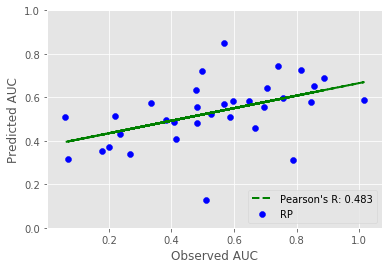

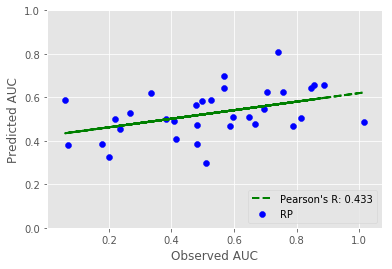

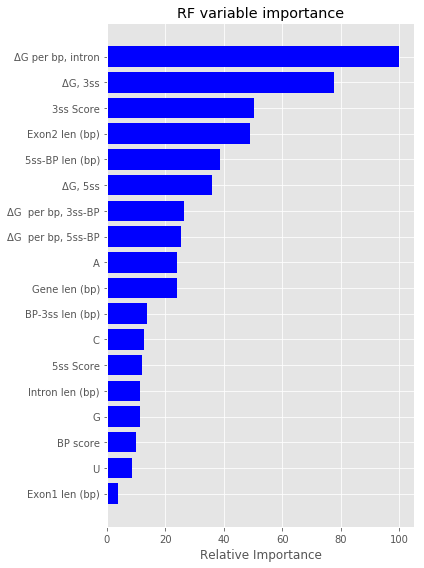

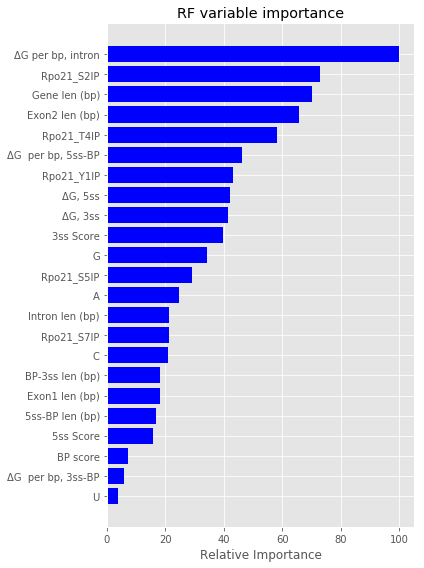

In [80]:
#BEST RIBOSOMAL PROTEIN

# Normal best: 0.4827552257052628 | max_features: 18; max_depth: 15; n_estimators: 10;
# Extended best: 0.4325119102278271 | max_features: 18; max_depth: 7; n_estimators: 20;

X,y,X2,y2 = get_data('nrp_cut')

rfr1 = ExtraTreesRegressor(n_estimators=10, 
                            criterion='mse', 
                            max_features=18, 
                            max_depth=15, 
                            n_jobs=2,
                            random_state=1337)

rfr2 = ExtraTreesRegressor(n_estimators=20, 
                            criterion='mse', 
                            max_features=18, 
                            max_depth=7, 
                            n_jobs=2,
                            random_state=1337)

kf = KFold(n_splits=5,shuffle=True,random_state=0)
predictions_rfr1_nrp = cross_val_predict(rfr1,X,y=y,cv=kf)
predictions_rfr2_nrp = cross_val_predict(rfr2,X2,y=y2,cv=kf)

fit_scatter(y,predictions_rfr1_nrp)
fit_scatter(y,predictions_rfr2_nrp)

print('Data')
print_stats(y,predictions_rfr1_nrp)
print('\n')
print('Extended Data')
print_stats(y2,predictions_rfr2_nrp)

rfr1.fit(X,y)
rfr2.fit(X2,y2)

names,names2 = get_variable_names('cut')
plot_importance(rfr1.feature_importances_,names,'nrp_cut')
plot_importance(rfr2.feature_importances_,names2,'nrp_cut_ext')

Normal best: 0.2969901764177368 | max_features: 25; max_depth: 5; n_estimators: 10;
Extended best: 0.40630448232918154 | max_features: 30; max_depth: 7; n_estimators: 20;
Best difference: 0.2582434619528223 | max_features: 30; max_depth: 7; n_estimators: 20;
Normal feature space
Coefficient of determination R^2: 0.2360352774266372
Mean squared error:               0.03984437679487179
Mean absolute error:              0.1488410256410256
Root mean squared error:          0.19961056283391365
Correlation Coefficient:          0.48848065665874996


Extended feature space
Coefficient of determination R^2: 0.38909635792549957
Mean squared error:               0.031861516874999996
Mean absolute error:              0.13109380341880345
Root mean squared error:          0.1784979464167585
Correlation Coefficient:          0.6250700537546936

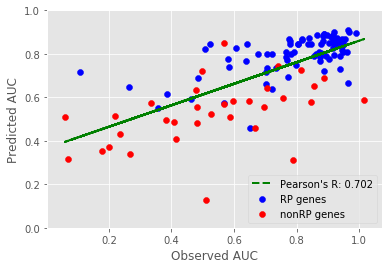

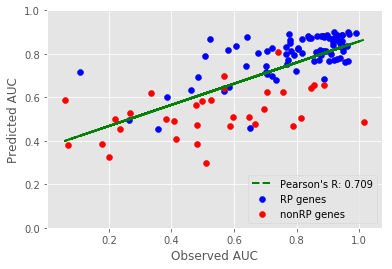

In [90]:
X,y1,_,_ = get_data('rp_cut')
X,y2,_,_ = get_data('nrp_cut')

fit_scatter_multi(y1,y2,predictions_rfr1_rp,predictions_rfr1_nrp,'cut_rp_nrp')
fit_scatter_multi(y1,y2,predictions_rfr2_rp,predictions_rfr2_nrp,'cut_rp_nrp_ext')

In [94]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

X,Y,X2,Y2 = get_data('full')
names = gene_features.drop(['ORG','Gene','AUC'], axis=1).columns
rf = ExtraTreesRegressor(random_state=1337,n_estimators=300)
scores = defaultdict(list)
X = X.values
Y = Y.values
#crossvalidate the scores on a number of different random splits of the data
for train_idx, test_idx in ShuffleSplit(len(X), 100, .3):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    r = rf.fit(X_train, Y_train)
    acc = r2_score(Y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(Y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)
print("Features sorted by their score:")
print (sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

/home/ghristov/miniconda3/envs/mlp/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Features sorted by their score:
[(0.1768, 'A'), (0.1609, '5ss-BP len (bp)'), (0.0754, 'UCG'), (0.048, 'Intron len (bp)'), (0.0457, 'U'), (0.0365, 'Exon2 len (bp)'), (0.0354, 'UUC'), (0.0345, 'CUU'), (0.0261, 'ΔG  per bp, 5ss-BP'), (0.0258, 'ACA'), (0.0225, 'ΔG per bp, intron'), (0.0203, 'Gene len (bp)'), (0.0171, 'AA'), (0.0167, 'ΔG, 5ss'), (0.014, 'UGC'), (0.012, 'GGG'), (0.0116, 'UA'), (0.0105, 'CUA'), (0.0103, 'GCA'), (0.0099, 'ACG'), (0.0094, 'AAA'), (0.0083, 'AUA'), (0.0077, 'GC'), (0.0074, 'CA'), (0.0061, 'UAU'), (0.0049, 'G'), (0.0037, 'CCA'), (0.0035, 'ΔG, 3ss'), (0.0034, 'AC'), (0.0029, 'GAU'), (0.0021, 'AUC.1'), (0.0018, 'CGC'), (0.0017, 'Exon1 len (bp)'), (0.0016, 'AGU'), (0.0015, 'GUC'), (0.0014, 'GAG'), (0.0007, 'AGA'), (0.0004, 'GAA'), (0.0001, 'AAC'), (-0.0, 'GG'), (-0.0003, 'CAC'), (-0.0003, 'ACC'), (-0.0005, 'UUA'), (-0.0006, 'CCU'), (-0.0009, 'GU'), (-0.001, 'CGU'), (-0.001, 'BP-3ss len (bp)'), (-0.001, 'AUU'), (-0.0011, 'AUG'), (-0.0012, 'UUG'), (-0.0012, 'GUG'), (-0

MSE: 0.0391
R2: -2.0055


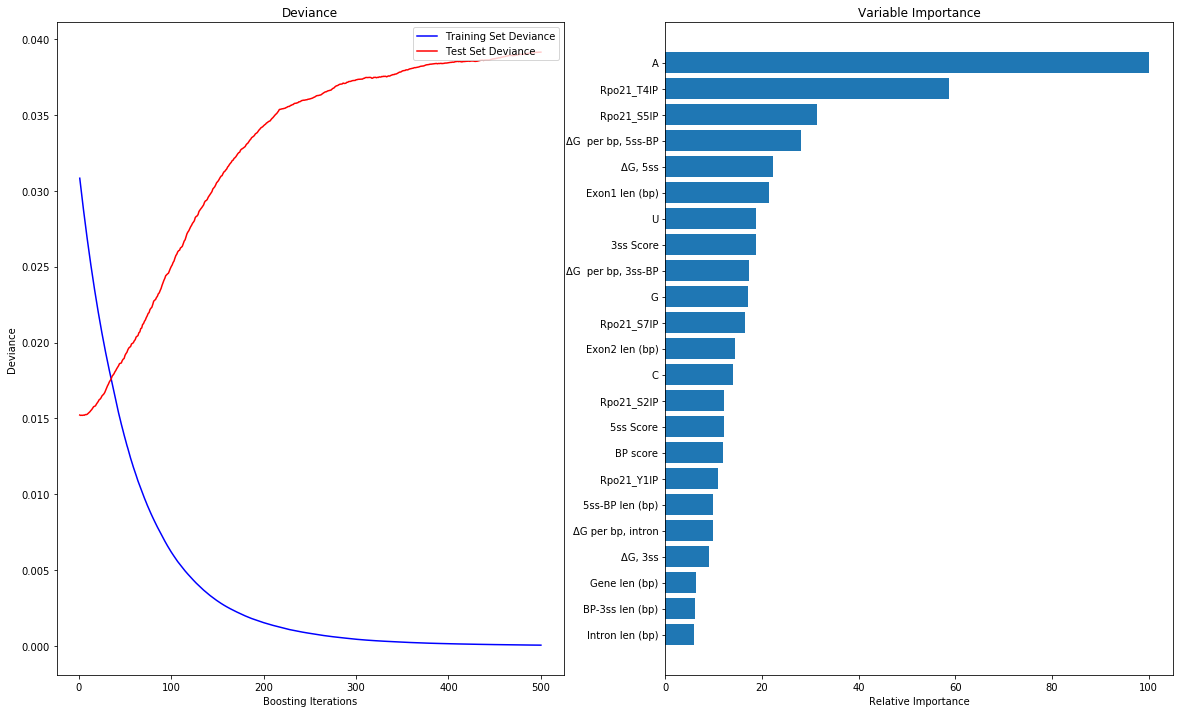

In [41]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Load data
names = extended_features_cut.drop(['ORG','Gene','AUC'], axis=1).columns
X2,y2,X,y = get_data('rp_cut')
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)
print("R2: %.4f" % r2_score(y_test,clf.predict(X_test)))

# #############################################################################
# Plot training deviance

# # compute test set deviance
# test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

# for i, y_pred in enumerate(clf.staged_predict(X_test)):
#     test_score[i] = clf.loss_(y_test, y_pred)


# plt.subplot(1, 2, 1)
# plt.title('Deviance')
# plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
#          label='Training Set Deviance')
# plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
#          label='Test Set Deviance')
# plt.legend(loc='upper right')
# plt.xlabel('Boosting Iterations')
# plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
plt.figure(figsize=(20, 12))
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
